# Evaluate on handpicked images

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import glob
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
MODEL_FILE = './blurdetector400p-171-0.86.h5'
INPUT_FOLDER = '../../../Downloads/merged/'
OUTPUT_DIM = 400

# Load keras model

In [3]:
#from keras import backend as K
#K.clear_session()
!nvidia-smi

Tue Jan 22 11:02:09 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 387.34                 Driver Version: 387.34                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro P4000        Off  | 00000000:00:05.0  On |                  N/A |
| 46%   40C    P8     8W / 105W |    347MiB /  8114MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
model = keras.models.load_model(MODEL_FILE)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 400, 400, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 200, 200, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 200, 200, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 100, 100, 64)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 640000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               64000100  
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
__________

# Load hand picked images

In [5]:
dir_content = glob.glob(INPUT_FOLDER+'*.jpg')
input_filenames = [x.split('/')[-1] for x in dir_content]
print(len(input_filenames))

22


In [6]:
input_truth_labels = []
input_images = []
input_files = []

for filename in input_filenames:
    
    # Determine the label
    if filename.split('_')[-1].split('.')[0] == 'good':
        label = 1
    else:
        label = 0
    
    # Read the raw image
    raw_img = cv.imread(INPUT_FOLDER+filename)
    
    # Initialize an black image in the correct dimensions
    img_out = np.zeros((OUTPUT_DIM, OUTPUT_DIM,3)).astype(np.uint8)
    
    # Scale the raw image to fit in the correct dimensions
    scale = OUTPUT_DIM/max(raw_img.shape[0],raw_img.shape[1])
    img = cv.resize(raw_img, (0,0), fx=scale, fy=scale)
    
    # Paste the scaled image in the correct dimensions
    img_out[ :img.shape[0], :img.shape[1] ] = img.astype(np.uint8)
    
    # Append the item to the list
    input_truth_labels.append(label)
    input_images.append(img_out)
    input_files.append(filename)
    
#   # Show the loaded images (optionally)
#     print('truth =',label,'for image:')
#     plt.imshow(img_out)
#     plt.show()
    
print(len(input_images), 'images processed')

22 images processed


In [7]:
# Convert Python list to numpy array
x_test = np.stack(input_images, axis=0)
y_test = np.asarray(input_truth_labels)
print(x_test.shape)
print(y_test.shape)
print(y_test)

(22, 400, 400, 3)
(22,)
[1 0 1 1 0 1 1 0 0 1 0 0 1 0 1 1 1 1 0 0 0 0]


# Predict images

In [8]:
# Perform prediction
y_tested = model.predict(x_test)

print(y_tested)
print(pd.Series(y_tested.reshape(-1)).describe())

# Since the model has a sigmoid function in the last dense layer, outputs are between 0-1. Squash into binary...
decision_boundary = 0.5
y_tested[ y_tested > decision_boundary ] = 1
y_tested[ y_tested <= decision_boundary ] = 0

[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [3.2844612e-20]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [5.3684057e-29]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]]
count    2.200000e+01
mean     1.492937e-21
std      7.002545e-21
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.284461e-20
dtype: float64


In [9]:
num_correct = 0
num_total = 0
correctly_predicted = y_tested.reshape(-1) == y_test

for state in correctly_predicted:
    if state == True:
        num_correct += 1
    num_total += 1

accuracy = num_correct/num_total
print("Accuracy: {}%".format(round(accuracy,4)*100))
print("Number of images wrongly predicted: {}".format(len(correctly_predicted[correctly_predicted==False])))

Accuracy: 50.0%
Number of images wrongly predicted: 11


# Show results

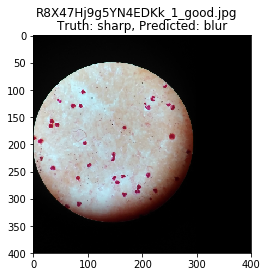

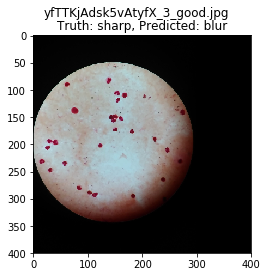

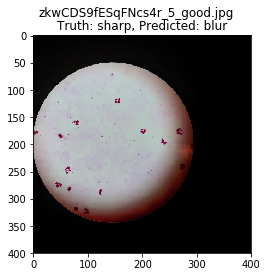

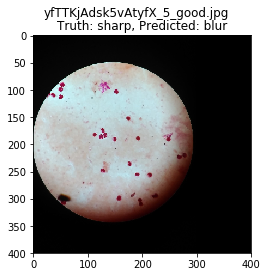

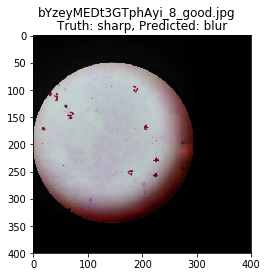

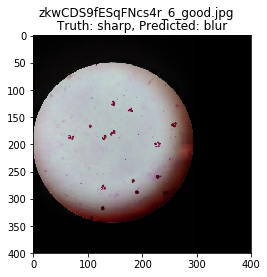

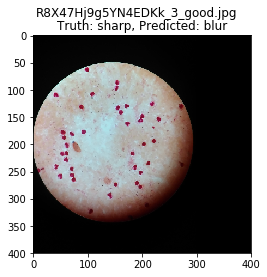

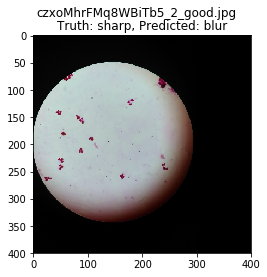

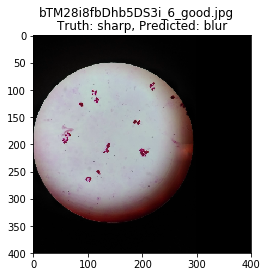

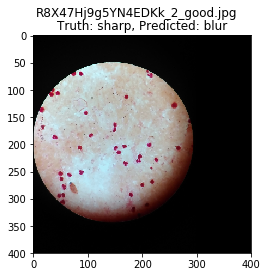

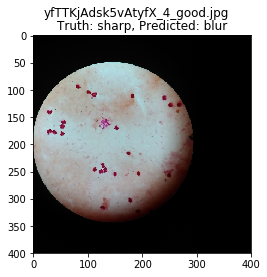

In [10]:
labels = {0:'blur', 1:'sharp'}

for i in range(len(input_images)):
    
    img = x_test[i]
    truth = int(y_test[i])
    predicted = int(y_tested[i])
            
    
    if predicted==0 and truth==1:
        plt.title('Truth: {t}, Predicted: {p}'.format(t=labels[truth], p=labels[predicted]))
        plt.suptitle('{}'.format(input_files[i]))
        plt.imshow(img)
        plt.show()

# Confusion matrix

In [11]:
import pandas as pd
y_actu = pd.Series(input_truth_labels, name='Actual')
y_pred = pd.Series(y_tested.reshape(-1), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

Predicted,0.0
Actual,
0,11
1,11


In [12]:
df_conf_norm = df_confusion / df_confusion.sum(axis=1)
df_conf_norm

,0.0,1.0
Actual,,
0,1.0,NaN
1,1.0,NaN
